# Notebook to explore files and test ML stuff on intrinsic data set 

The idea is to compare this to Rikhav's cut based analysis. 

In [146]:
import numpy as np
import glob
import os
import tqdm
import itertools
import matplotlib.pyplot as plt
import time
import copy
from fastespy.readpydata import convert_data_to_ML_format
from fastespy.plotting import plot_2d_hist, plot_scatter_w_hist
from fastespy.ml import MLHyperParTuning, significance
from fastespy import feldman_cousins as fc

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

### Explore the data

Let's take a look at the data from Rikhav's intrinsic runs, done at $R_N = 0.3$ and a gain width product of 1.5 GHz. The trigger threshold was set to 20mV.

In [5]:
path = "../../../data-01152021/"
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
print(files[0])

17
../../../data-01152021/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy


In [6]:
for f in files:
    print(os.path.basename(f))

0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-3-fit000.npy
0.3RN-1.5GHz-light-000-fit.npy
0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-9-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-13-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-14-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-1-fit000.npy
0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-6-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-11-fit000.npy
0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-8-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-12-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hr-2-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-17-fit000.npy
0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-7-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-10-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-15-fit000.npy
0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-18-fit000.npy


Load one file and inspect it's contents:

In [7]:
f
print(len(x.keys()))  # number of recorded triggers
#print(x.keys())  # in Rikhav's files, the keys are integers from 1,..., N_trigger 
x[1]

1709


{'start time in hrs': 0.01628305595,
 'end time in hrs': 0.0162831115,
 'data': array([-0.0012398 , -0.00112535, -0.00089647, ...,  0.00028611,
        -0.00024796,  0.00020981]),
 'time': array([58.61900142, 58.61900144, 58.61900146, ..., 58.61920136,
        58.61920138, 58.6192014 ]),
 'rise time': 1.7650903275199694e-06,
 'rise time error': 1.5309936511128432e-08,
 'decay time': 2.287605898160283e-05,
 'decay time error': 2.5212876321734424e-07,
 'constant': 0.0004085272957005441,
 'constant error': 3.960175446925966e-05,
 'amplitude': 0.01804428397975213,
 'amplitude error': 7.416273727863304e-05,
 'pulse integral raw': -7.72645215374739e-07,
 'pulse integral raw error': 3.000000248221113e-07,
 'pulse height': -0.031212677749656446,
 'pulse height error': 0.0014603982455307404,
 'trigger time': 2.966826527028843e-05,
 'chi2 reduced': 1.7620628040853559,
 'voltage error': 0.0015,
 'pulse integral fit': -8.3209149181234e-07}

From this first look, define the key words that you would like to save

In [8]:
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
         ]

for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

print(feature_names)

['rise time', 'decay time', 'constant', 'amplitude', 'pulse height', 'chi2 reduced', 'pulse integral fit']


In [9]:
light_cleaning_cuts = {
    "chi2 reduced": "chi2 < 6.",
    "decay time" : "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)", # from gaussian fit, 5 sigma interval 
}

In [10]:
x[3]

{'start time in hrs': 0.06746660554444445,
 'end time in hrs': 0.06746666109444445,
 'data': array([-0.00249866, -0.00200275, -0.00192645, ..., -0.0003624 ,
        -0.00017166, -0.00028611]),
 'time': array([242.87977996, 242.87977998, 242.87978   , ..., 242.8799799 ,
        242.87997992, 242.87997994]),
 'rise time': 2.0000000107214944e-06,
 'rise time error': 1.377362396024171e-07,
 'decay time': 7.499506955849276e-05,
 'decay time error': 5.824822979657124e-07,
 'constant': 0.0015771290794995407,
 'constant error': 0.0001717866095362907,
 'amplitude': 0.009558628967193424,
 'amplitude error': 0.00020972530140374508,
 'pulse integral raw': -1.0809606397494198e-06,
 'pulse integral raw error': 2.9999981165929057e-07,
 'pulse height': -0.023798079716563704,
 'pulse height error': 0.0013282133904637093,
 'trigger time': 2.317340158697334e-05,
 'chi2 reduced': 4.309428683830796,
 'voltage error': 0.0015,
 'pulse integral fit': -1.29961073176814e-06}

In [11]:
result = {'type': []}
t_tot_hrs = 0.

id_rejected = []

data = {"time": [], "data": []}
# loop through files
for f in tqdm.tqdm(files): 
    x = np.load(f, allow_pickle=True).tolist()

    # for each file: calculate observation time
    t_start = 1e10
    t_stop = 0.
    
    if 'light' in f:
        print(len(x))
        id_rejected.append([])
    
    # loop through triggers
    for i in range(1,len(x.keys())+1):
                # light sample cleaning
        if 'light' in f:
            m = True
            for c, v in light_cleaning_cuts.items():
                #print(i, v, {c.split()[0]: x[i][c]})
                m &= eval(v, {c.split()[0]: x[i][c]})   
            
            if not m:
                id_rejected[-1].append(i)
                continue

        for name in feature_names:
            if not name in result.keys():
                result[name] = []
                
            result[name].append(x[i][name])
            
        # save raw data
        data['time'].append(x[i]['time'])
        data['data'].append(x[i]['data'])
        
        if 'intrinsic' in f:
            if x[i]['end time in hrs'] > t_stop:
                t_stop = x[i]['end time in hrs']
            if x[i]['start time in hrs'] < t_start:
                t_start = x[i]['start time in hrs']
            result['type'].append(0)
        
        if 'light' in f:
            result['type'].append(1)

    if 'intrinsic' in f:
        t_tot_hrs += t_stop - t_start  # only add for dark count rate


        
for k in ['time', 'data']:
    data[k] = np.array(data[k])
    
# convert into into numpy arrays
for k, v in result.items():
    if k == 'type':
        dtype = np.bool
    else:
        dtype = np.float32
    result[k] = np.array(v, dtype=dtype)

 18%|█▊        | 3/17 [00:01<00:05,  2.46it/s]

2627


100%|██████████| 17/17 [00:07<00:00,  2.41it/s]


In [12]:
len(id_rejected)

1

In [13]:
for rej in id_rejected:
    print("Rejected {0:n} triggers in light file".format(len(rej)))

Rejected 1561 triggers in light file


### Plot some histograms

Rikhav said the following: "The fit parameters I use for then selecting data are pulse height, amplitude, pulse integral, the exponential rise and decay times, and the chi2"

In [14]:
# define labels
label = {
    'rise time': r'Rise time $(\mu\mathrm{s})$',
    'decay time': r'Decay time $(\mu\mathrm{s})$',
    'pulse height': r'Pulse height (mV)',
    'amplitude': r'Amplitude (mV)',
    'pulse integral fit': r'Pulse Integral (mV $\mu$s)',
    'chi2 reduced': r'$\chi^2/$d.o.f.',
    'constant': 'Constant offset (mV)'
}

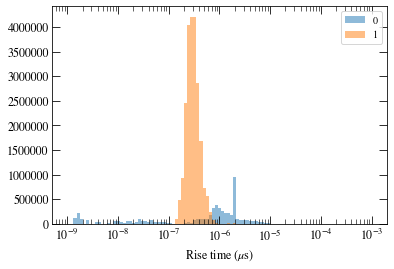

In [15]:
k = 'rise time'
bins = np.logspace(-9., -3., 100)

for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, density=True, alpha=0.5)

plt.legend()
plt.xlabel(label[k])
plt.gca().set_xscale('log')
plt.savefig(f"{k}.png")

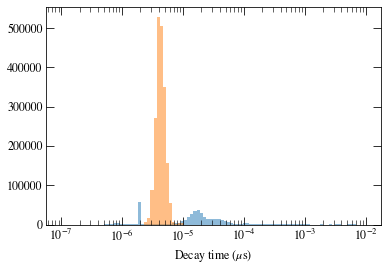

In [16]:
k = 'decay time'
bins = np.logspace(-7., -2., 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')
plt.savefig(f"{k}.png")

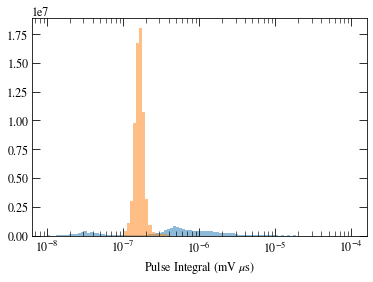

In [17]:
k = 'pulse integral fit'
bins = np.logspace(-8., -4., 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(-result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')
plt.savefig(f"{k}.png")

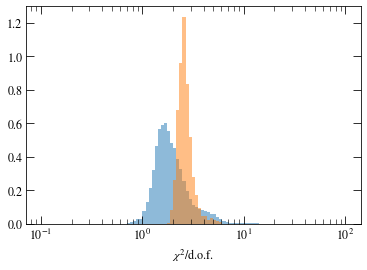

In [18]:
k = 'chi2 reduced'
bins = np.logspace(-1, 2, 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')
plt.savefig(f"{k}.png")

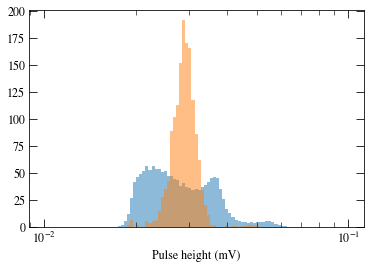

In [19]:
k = 'pulse height'
bins = np.logspace(-2, -1, 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(-result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')
plt.savefig(f"{k}.png")

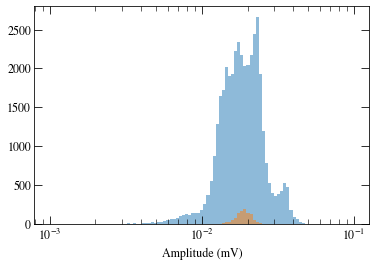

In [20]:
k = 'amplitude'
bins = np.logspace(-3, -1, 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')
plt.savefig(f"{k}.png")

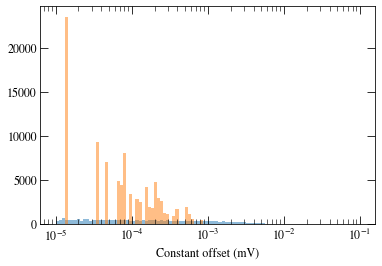

In [21]:
k = 'constant'
bins = np.logspace(-5, -1, 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')
plt.savefig(f"{k}.png")

In [174]:
result["constant"].max()

0.55730706

# Apply machine learning

Test machine learning algorithms to separate light from background.

In [25]:
from sklearn.model_selection import KFold, StratifiedKFold

In [22]:
feature_names

['rise time',
 'decay time',
 'constant',
 'amplitude',
 'pulse height',
 'chi2 reduced',
 'pulse integral fit']

In [23]:
feature_names_reduced = ['rise time', 'decay time', 'pulse integral fit']

In [28]:
X, y = convert_data_to_ML_format(result,
                                 feature_names,
                                 #feature_names_reduced,
                                 bkg_type=0,
                                 signal_type=1)
print(X.shape)

(40646, 7)


In [29]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print (X_train.shape, X_test.shape, np.sum(y_train), np.sum(y_test))

TRAIN: [    0     1     3 ... 40642 40643 40645] TEST: [    2    24    29 ... 40636 40641 40644]
(32516, 7) (8130, 7) 852 214
TRAIN: [    0     1     2 ... 40641 40643 40644] TEST: [   12    13    18 ... 40615 40642 40645]
(32517, 7) (8129, 7) 853 213
TRAIN: [    0     1     2 ... 40643 40644 40645] TEST: [    3     5    14 ... 40637 40638 40640]
(32517, 7) (8129, 7) 853 213
TRAIN: [    2     3     5 ... 40643 40644 40645] TEST: [    0     1     4 ... 40625 40626 40628]
(32517, 7) (8129, 7) 853 213
TRAIN: [    0     1     2 ... 40642 40644 40645] TEST: [    7    11    23 ... 40632 40639 40643]
(32517, 7) (8129, 7) 853 213


In [40]:
split_id = 0
train_idx, test_idx = list(skf.split(X, y))[split_id]

In [130]:
ml = MLHyperParTuning(X[train_idx], y[train_idx],
                      X_test=X[test_idx],
                      y_test=y[test_idx],
                      idx_test=test_idx,
                      valid_fraction=0.2,
                      stratify=True,
                      scale=True,
                      random_state=42,
                      n_splits=5)

In [131]:
ml.make_sig_scorer(t_obs=t_tot_hrs * 3600.)

In [132]:
ml.perform_grid_search(classifier='dt',
                       refit='Significance',
                       coarse_grid=True,
                       n_jobs=8)

Fitting 5 folds for each of 570 candidates, totalling 2850 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   32.5s
[Parallel(n_jobs=8)]: Done 2452 tasks      | elapsed:   52.1s
[Parallel(n_jobs=8)]: Done 2850 out of 2850 | elapsed:  1.0min finished


The parameter search took 62.54 s
Profiling over parameters
Refitting on whole test data set and computing learning curve and confusion matrix
[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.5s finished


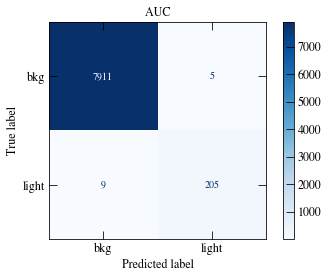

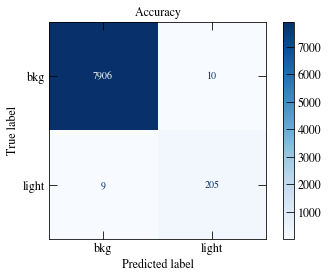

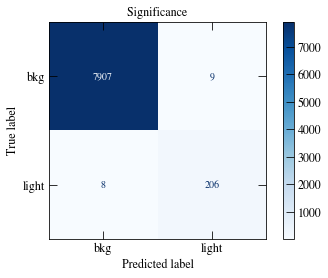

In [133]:
ml.plot_confusion_matrix(ml.results, ml.scoring)

In [144]:
ml.results['confusion_matrix_test']['Significance'][0,1]

9

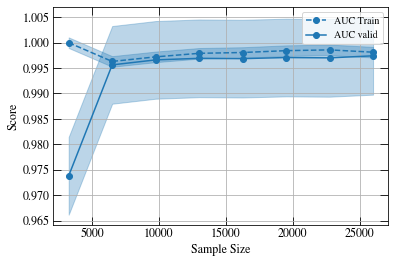

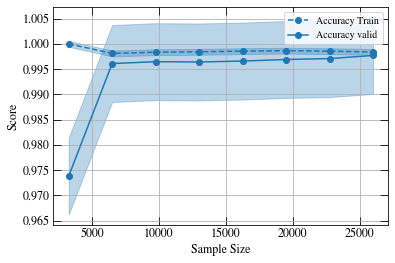

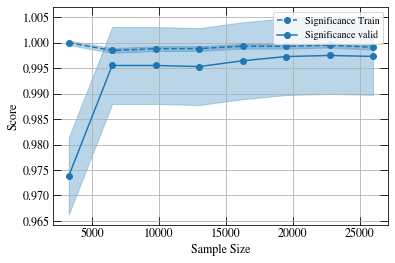

In [134]:
ml.plot_learning_curve(ml.results)

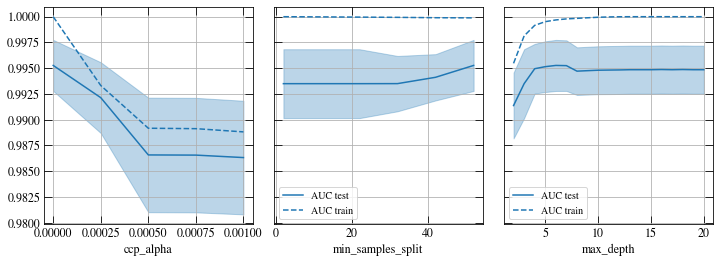

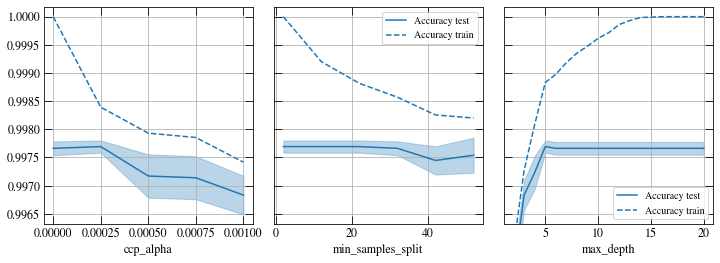

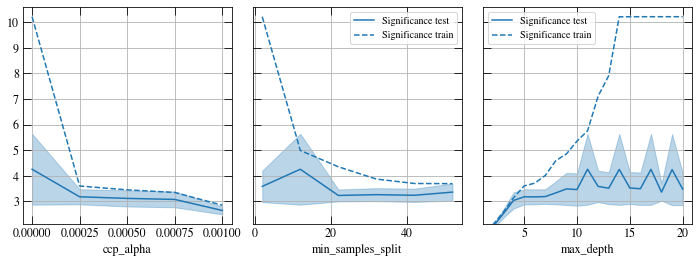

In [135]:
ml.plot_parameter_profiles(ml.results, ml.scoring, classifier=ml.classifier)

In [136]:
for k, v in ml.scoring.items():
    print(k, ml.results['best_params'][k])

AUC {'criterion': 'gini', 'min_samples_leaf': 1, 'ccp_alpha': 0.0, 'max_depth': 6, 'min_samples_split': 52}
Accuracy {'criterion': 'gini', 'min_samples_leaf': 1, 'ccp_alpha': 0.00025, 'max_depth': 5, 'min_samples_split': 2}
Significance {'criterion': 'gini', 'min_samples_leaf': 1, 'ccp_alpha': 0.0, 'max_depth': 11, 'min_samples_split': 12}


In [137]:
for k, v in ml._scoring.items():
    print(k, ml.results['score_test'][k], ml.results['score_train'][k])

AUC 0.9879240199666591 0.9995282775480574
Accuracy 0.9976629766297663 0.9983392791241235
Significance 3.332057195164821 4.3091872982082835


In [140]:
ml.print_performance_report(ml.results, ml.scoring, ml.t_obs)

==== AUC : bkg_pred ====
train: 1.743e-05
test: 1.341e-05
==== AUC : tp_efficiency ====
train: 9.613e-01
test: 9.579e-01
==== AUC : score ====
train: 9.995e-01
test: 9.879e-01
==== AUC : Significance ====
train: 3.776
test: 4.143
==== Accuracy : bkg_pred ====
train: 2.212e-05
test: 2.681e-05
==== Accuracy : tp_efficiency ====
train: 9.754e-01
test: 9.579e-01
==== Accuracy : score ====
train: 9.983e-01
test: 9.977e-01
==== Accuracy : Significance ====
train: 3.490
test: 3.179
==== Significance : bkg_pred ====
train: 1.274e-05
test: 2.413e-05
==== Significance : tp_efficiency ====
train: 9.824e-01
test: 9.626e-01
==== Significance : score ====
train: 4.309e+00
test: 3.332e+00
==== Significance : Significance ====
train: 4.309
test: 3.332


### Save results

In [167]:
results = ml.make_result_dict()

Add Feldman & Cousins confidence interval for dark current rate

In [157]:
n_b = 0
n_obs = np.arange(ml.results['confusion_matrix_test']['Significance'][0,1] * 5)
mus = np.linspace(0, ml.results['confusion_matrix_test']['Significance'][0,1] * 3, 2401)
alpha = 0.9

print(mus.shape, n_obs.shape)

lower_limits_mu, upper_limits_mu = fc.poissonian_feldman_cousins_interval(
        n_obs=n_obs,
        n_b=n_b,
        mus=mus,
        alpha=alpha,
        fix_discrete_n_pathology=False,
        n_jobs=8)

lower_limits = lower_limits_mu[:, 0]
upper_limits = upper_limits_mu[:, 0]

(2401,) (45,)


/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/feldman_cousins.py:313: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 27. Setting the upper limit to inf.
  'Setting the upper limit to inf.').format(n))
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/feldman_cousins.py:313: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 28. Setting the upper limit to inf.
  'Setting the upper limit to inf.').format(n))
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/feldman_cousins.py:313: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 29. Setting the upper limit to inf.
  'Setting the upper limit to inf.').format(n))
/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/feldman_cousins.py:313: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 30. Setting the upper limit to inf.
  'Setting the upper limit to inf.')

In [168]:
results['dark_current'] = {}
for k in ml.scoring.keys():
    results['dark_current'][k] = np.array([
        lower_limits[ml.results['confusion_matrix_test']['Significance'][0,1]] * (ml.y_test.size + ml.y_train.size) / ml.y_test.size,
        ml.results['bkg_pred_test']['Significance'],
        upper_limits[ml.results['confusion_matrix_test']['Significance'][0,1]] * (ml.y_test.size + ml.y_train.size) / ml.y_test.size
    ]) / ml.t_obs
    print (k, results['dark_current'][k])

AUC [1.17046397e-05 2.41332777e-05 4.09964056e-05]
Accuracy [1.17046397e-05 2.41332777e-05 4.09964056e-05]
Significance [1.17046397e-05 2.41332777e-05 4.09964056e-05]


In [169]:
#ml.save("r{ml._classifier}_cleaned.npy")
np.save("r{ml._classifier}_cleaned_reduced.npy", results)

### Plot misidentified pulses in test sample

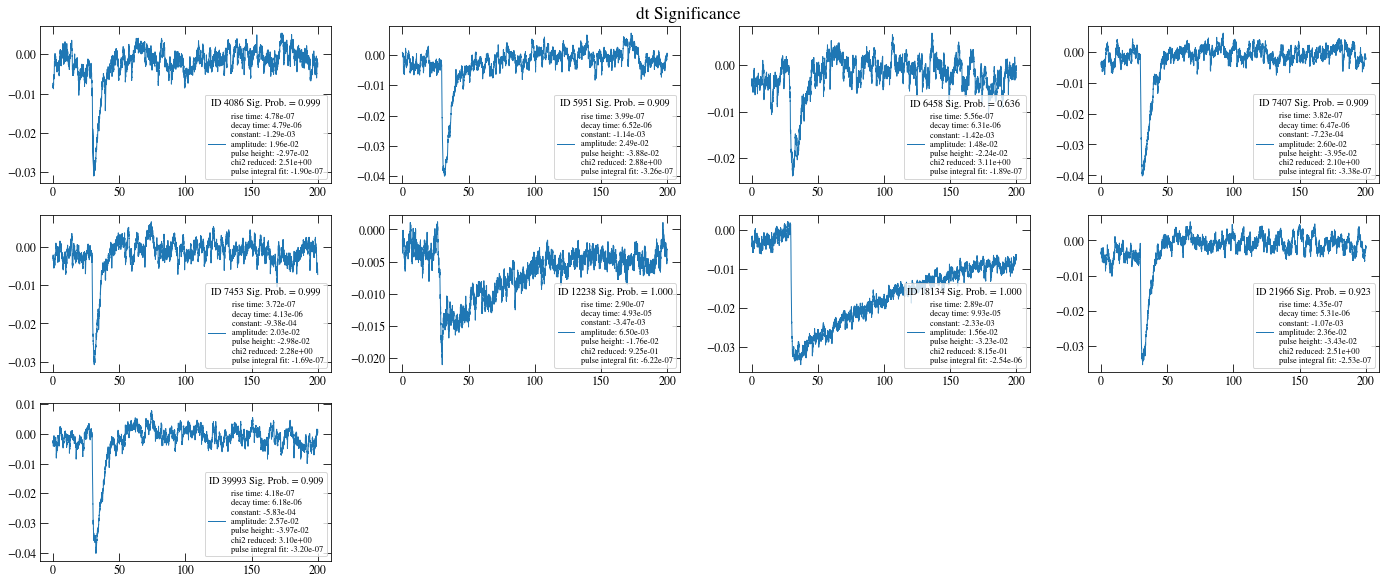

In [170]:
ml.plot_misidentified_time_lines(results,
                                 scorer="Significance",
                                 data_time=data['time'],
                                 data_voltage=data['data'],
                                 X=X,
                                 feature_names=feature_names)

In [60]:
m_correct_id = (ml.y_test == 1) & (ml.y_pred_test['Significance'] == 1)
n_correct_id = np.sum(m_correct_id)
print(n_correct_id)

213


0.4835680751173709


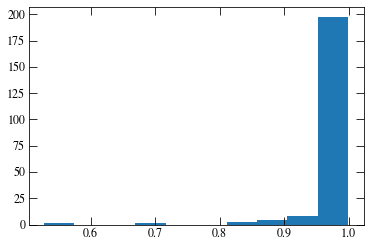

In [61]:
plt.hist(ml._prob_test[scorer][:,1][m_correct_id])
print(np.sum(ml._prob_test[scorer][:,1][m_correct_id] > 0.99) / n_correct_id)

## Test performance of best classifier on less features

In [68]:
feature_names = ['rise time' ,'decay time', 'pulse integral fit']

In [95]:
X_less, y_less = convert_data_to_ML_format(result, feature_names, bkg_type=0, signal_type=1)
print(X_less.shape)

(40646, 3)


In [94]:
y_less.sum()

1066

In [81]:
from fastespy.ml import clf, default_pars
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [73]:
config = copy.deepcopy(default_pars['mlp'])
config.update(ml.results['best_params']['Significance'])
c = clf['mlp'](**config)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_less, y_less, 
                                                    random_state=42,
                                                    stratify=y_less, 
                                                    test_size=0.2,
                                                    shuffle=True
                                                   )

In [89]:
c.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [90]:
y_pred_train = c.predict(X_train)
y_pred_test = c.predict(X_test)

In [91]:
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)

In [92]:
confusion_matrix_train

array([[31663,     0],
       [  853,     0]])

In [84]:
bkg_train, tp_eff_train = ml.compute_bkg_rate_tp_efficiency(confusion_matrix_train,
                                                            y_train, 
                                                            n_triggers=y_train.size + y_test.size
                                                           )

bkg_test, tp_eff_test = ml.compute_bkg_rate_tp_efficiency(confusion_matrix_test,
                                                          y_test, 
                                                          n_triggers=y_train.size + y_test.size
                                                          )

In [85]:
print (bkg_train / (t_tot_hrs * 3600.), tp_eff_train)
print (bkg_test / (t_tot_hrs * 3600.), tp_eff_test)

0.0 0.0
0.0 0.0


### Plot the sensitivity

In [63]:
print(significance(3.486e-5, obs_time=t_tot_hrs * 3600., n_s = 2.8e-5, e_d=0.5, e_a=9.765e-01))
print(significance(8.716e-06, obs_time=t_tot_hrs * 3600., n_s = 2.8e-5, e_d=0.5, e_a=1.))

2.900723645338985
4.953435169066349


In [64]:
# sensitivity from Rikhav's result
print(significance(7.52e-6, obs_time=t_tot_hrs * 3600., n_s = 2.8e-5, e_d=0.5, e_a=0.82))
print(significance(4.63e-6, obs_time=t_tot_hrs * 3600., n_s = 2.8e-5, e_d=0.5, e_a=0.71))

4.414883729476727
4.547841579400519


In [65]:
print (t_tot_hrs, t_tot_hrs/24.)

517.906026640339 21.57941777668079


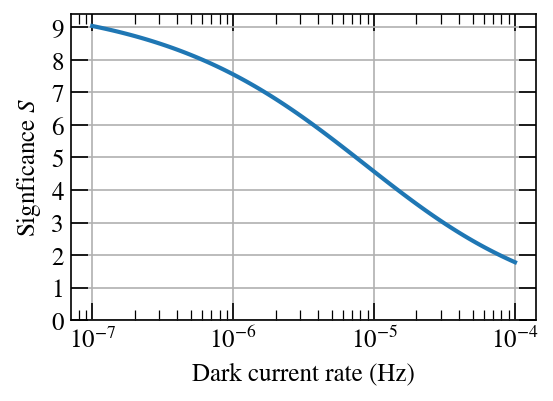

In [66]:
plt.figure(figsize=(4,3), dpi=150)
n_b = np.logspace(-7., -4., 100)
obs_time = 20. * 24. * 3600.
plt.semilogx(n_b, significance(n_b, obs_time=obs_time), lw=2)
plt.grid()
plt.yticks(np.arange(10))
plt.xlabel("Dark current rate (Hz)")
plt.ylabel("Signficance $S$")
plt.subplots_adjust(bottom=0.2)
plt.savefig("significance_vs_dark_current.png")